<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Training log: 1 epoch (128 / 60000 train. data). Loss: 2.435809373855591
Training log: 1 epoch (1408 / 60000 train. data). Loss: 1.8232277631759644
Training log: 1 epoch (2688 / 60000 train. data). Loss: 1.375369668006897
Training log: 1 epoch (3968 / 60000 train. data). Loss: 1.2031720876693726
Training log: 1 epoch (5248 / 60000 train. data). Loss: 0.8374272584915161
Training log: 1 epoch (6528 / 60000 train. data). Loss: 0.7198622822761536
Training log: 1 epoch (7808 / 60000 train. data). Loss: 0.6596168875694275
Training log: 1 epoch (9088 / 60000 train. data). Loss: 0.5850553512573242
Training log: 1 epoch (10368 / 60000 train. data). Loss: 0.4894704818725586
Training log: 1 epoch (11648 / 60000 train. data). Loss: 0.5056400895118713
Training log: 1 epoch (12928 / 60000 train. data). Loss: 0.44230204820632935
Training log: 1 epoch (14208 / 60000 train. data). Loss: 0.44393062591552734
Training log: 1 epoch (15488 / 60000 train. data). Loss: 0.48126766085624695
Training log: 1 epoc

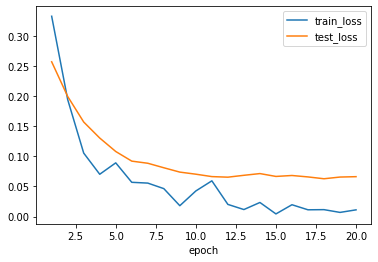

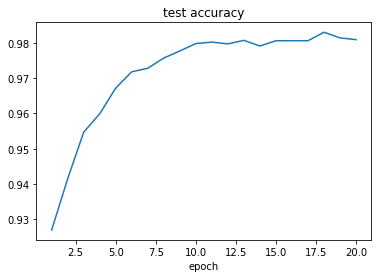

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

 
class Network1(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 1000, False)
        self.fc2 = torch.nn.Linear(1000, 10, False)
 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
 
        return f.log_softmax(x, dim=1)
 
 
def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    return {'train': train_loader, 'test': test_loader}
 
 
if __name__ == '__main__':
    # 学習回数
    epoch = 20
 
    # 学習結果の保存用
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
    }
 
    # ネットワークを構築
    net: torch.nn.Module = Network1()
 
    # MNISTのデータローダーを取得
    loaders = load_MNIST()
 
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
 
    for e in range(epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
        for i, (data, target) in enumerate(loaders['train']):
            # 全結合のみのネットワークでは入力を1次元に
            # print(data.shape)  # torch.Size([128, 1, 28, 28])
            data = data.view(-1, 28*28)
            # print(data.shape)  # torch.Size([128, 784])
 
            optimizer.zero_grad()
            output = net(data)
            loss = f.nll_loss(output, target)
            loss.backward()
            optimizer.step()
 
            if i % 10 == 0:
                print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(e+1,
                                                                                         (i+1)*128,
                                                                                         loss.item())
                      )
 
        history['train_loss'].append(loss)
 
        """ Test Part """
        # 学習のストップ
        net.eval()  # または net.train(False) でも良い
        test_loss = 0
        correct = 0
 
        with torch.no_grad():
            for data, target in loaders['test']:
                data = data.view(-1, 28 * 28)
                output = net(data)
                test_loss += f.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
 
        test_loss /= 10000
 
        print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                         correct / 10000))
 
        history['test_loss'].append(test_loss)
        history['test_acc'].append(correct / 10000)
 
    # 結果の出力と描画
    print(history)
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'], label='train_loss')
    plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig('loss.png')
 
    plt.figure()
    plt.plot(range(1, epoch+1), history['test_acc'])
    plt.title('test accuracy')
    plt.xlabel('epoch')
    plt.savefig('test_acc.png')

In [1]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
N = 10
L = 5

In [17]:
S0 = torch.sign(torch.randn(9,N))

SL = torch.sign(torch.randn(9,N))


M = len(S0)
print(M)
print(N)
print(S0.shape)
print(S0[0].shape)

9
10
torch.Size([9, 10])
torch.Size([10])


In [18]:
alpha = M / N
print(alpha)

0.9


In [19]:
D = torch.Tensor([[1,2,3],[2,3,4]])
print(D)
print(D.shape)
print("M:",len(D)) #M
print("N:",len(D[0])) #N

tensor([[1., 2., 3.],
        [2., 3., 4.]])
torch.Size([2, 3])
M: 2
N: 3


In [23]:
def spin_overlap(x,y):
  spin_overlap = 0
  for i in range (len(x[0])) :

    spin_overlap = spin_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(spin_overlap/(len(x)*len(x[0])))

print(spin_overlap(S0,S0))


tensor(1.)


In [36]:
def bond_overlap(x,y):
  bond_overlap = 0
  for i in range (len(x[0])) :

    bond_overlap = bond_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(bond_overlap/(len(x)*len(x[0])))

In [25]:
S_a = torch.Tensor([[1,-1],[-1,1],[1,-1]])
S_b = torch.Tensor([[1,-1],[1,1],[1,1]])
print(spin_overlap(S_a,S_b))
print(spin_overlap(S_a,S_a))

tensor(0.3333)
tensor(1.)


In [26]:
a1 = torch.dot(S_a.T[0],S_b.T[0])
a2 = torch.dot(S_a.T[1],S_b.T[1])
a3 = (a1 + a2)/(2*3)
print(a3)

tensor(0.3333)


In [30]:
def MSE(t, y):
    mse = torch.mean(torch.sum(torch.square(t-y),axis =1),axis = 0)
    return mse

In [31]:
print(MSE(S0,SL))

tensor(19.5556)


In [32]:
A = torch.Tensor([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (torch.sum(torch.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)

tensor([[  9.,  25.,   1.],
        [ 16., 144.,   1.]])
tensor([ 5.0000, 13.0000,  1.4142])
tensor([[0.6000, 0.3846, 0.7071],
        [0.8000, 0.9231, 0.7071]])
tensor([[1.8974, 1.2163, 2.2361],
        [2.5298, 2.9190, 2.2361]])


In [33]:
def weight_norm(x):
    x_norm = (torch.sum(torch.square(x),axis=0)**(1/2))
    return x_norm

In [37]:
w_a = torch.Tensor([[1,0,1],[1,0,0],[0,1,0]]) 
w_b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]) 
J_a = w_a / (weight_norm(w_a)) * (3**(1/2))
J_b = w_b / (weight_norm(w_b)) * (3**(1/2))


print(J_a)
print(J_b)
print(len(J_a[0]))

print(bond_overlap(J_a,J_b))
print(bond_overlap(J_a,J_a))

tensor([[1.2247, 0.0000, 1.7321],
        [1.2247, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000]])
tensor([[1.7321, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000],
        [0.0000, 0.0000, 1.7321]])
3
tensor(0.2357)
tensor(1.)


In [81]:
class Network1(torch.nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1_1 = torch.nn.Linear(N, N, False)
        self.fc2_1 = torch.nn.Linear(N, N, False)
        self.fc3_1 = torch.nn.Linear(N, N, False)
        self.fc4_1 = torch.nn.Linear(N, N, False)
        self.fc5_1 = torch.nn.Linear(N, N, False)

        torch.nn.init.normal_(self.fc1_1.weight, 0.0, 1.0)
        torch.nn.init.normal_(self.fc2_1.weight, 0.0, 1.0)
        torch.nn.init.normal_(self.fc3_1.weight, 0.0, 1.0)
        torch.nn.init.normal_(self.fc4_1.weight, 0.0, 1.0)
        torch.nn.init.normal_(self.fc5_1.weight, 0.0, 1.0)

 
    def forward(self, x):
        x = torch.tanh(self.fc1_1(x))
        S1_1 = torch.sign(x)
        x = torch.tanh(self.fc2_1(x))
        S2_1 = torch.sign(x)
        x = torch.tanh(self.fc3_1(x))
        S3_1 = torch.sign(x)
        x = torch.tanh(self.fc4_1(x))
        S4_1 = torch.sign(x)
        x = torch.tanh(self.fc5_1(x))
        S5_1 = torch.sign(x)

        return S1_1, S2_1, S3_1, S4_1, S5_1



In [82]:
if __name__ == '__main__':
    # 学習回数
    n_epoch = 1000
 
    # 学習結果の保存用
    history = {
        'train_loss_1': [],
    }
 
    # ネットワークを構築
    net: torch.nn.Module = Network1()
 
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)
 
    for n in range(n_epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
 
        optimizer.zero_grad()
        output = net(S0)
        loss = MSE(output[0], SL)
        loss.backward()
        optimizer.step()
 
        print('EPOCH ', n + 1, ' | train_loss_1 ',loss)
        
 
        history['train_loss_1'].append(loss)


EPOCH  1  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  2  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  3  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  4  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  5  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  6  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  7  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  8  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  9  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  10  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  11  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  12  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  13  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  14  | train_loss_1  tensor(22.2222, grad_fn=<MeanBackward1>)
EPOCH  15  | train_loss_1  tensor(22.2222, grad_fn=<MeanB

{'train_loss_1': [tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, grad_fn=<MeanBackward1>), tensor(22.2222, 

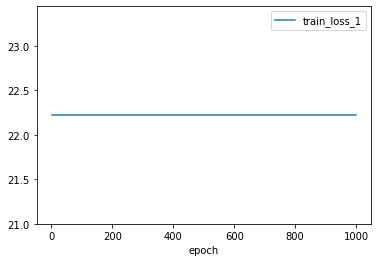

In [83]:
# 結果の出力と描画
print(history)
plt.figure()
plt.plot(range(1, n_epoch+1), history['train_loss_1'], label='train_loss_1')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss.png')
 
